### Initialize Data

In [1]:
import torch
import torch.optim as optim
from focal_loss import FocalLoss
from mock_dataset import MockOutfitDataset
from outfit_model import OutfitCompatibilityModel
import torch.nn as nn

# Instantiate the mock dataset and dataloader
mock_dataset = MockOutfitDataset()
dataloader = torch.utils.data.DataLoader(mock_dataset, batch_size=50, shuffle=True)

### Visualize Data

Batch 1 - Shape of images: torch.Size([50, 3, 224, 224]), Texts: ('mock description 343', 'mock description 346', 'mock description 596', 'mock description 897', 'mock description 952', 'mock description 534', 'mock description 513', 'mock description 290', 'mock description 224', 'mock description 66', 'mock description 263', 'mock description 683', 'mock description 911', 'mock description 682', 'mock description 211', 'mock description 413', 'mock description 35', 'mock description 598', 'mock description 341', 'mock description 930', 'mock description 362', 'mock description 879', 'mock description 874', 'mock description 657', 'mock description 643', 'mock description 281', 'mock description 86', 'mock description 641', 'mock description 26', 'mock description 629', 'mock description 36', 'mock description 411', 'mock description 204', 'mock description 735', 'mock description 993', 'mock description 823', 'mock description 748', 'mock description 945', 'mock description 7', 'mock

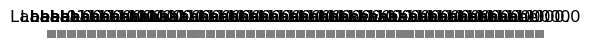

Batch 2 - Shape of images: torch.Size([50, 3, 224, 224]), Texts: ('mock description 610', 'mock description 632', 'mock description 814', 'mock description 192', 'mock description 147', 'mock description 985', 'mock description 824', 'mock description 811', 'mock description 941', 'mock description 756', 'mock description 878', 'mock description 546', 'mock description 801', 'mock description 918', 'mock description 938', 'mock description 344', 'mock description 648', 'mock description 571', 'mock description 578', 'mock description 87', 'mock description 769', 'mock description 95', 'mock description 238', 'mock description 474', 'mock description 586', 'mock description 441', 'mock description 961', 'mock description 366', 'mock description 348', 'mock description 296', 'mock description 561', 'mock description 108', 'mock description 256', 'mock description 662', 'mock description 215', 'mock description 199', 'mock description 537', 'mock description 608', 'mock description 707', 

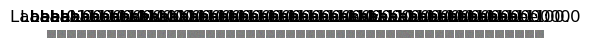

Batch 3 - Shape of images: torch.Size([50, 3, 224, 224]), Texts: ('mock description 710', 'mock description 162', 'mock description 353', 'mock description 365', 'mock description 808', 'mock description 305', 'mock description 830', 'mock description 535', 'mock description 83', 'mock description 159', 'mock description 842', 'mock description 332', 'mock description 264', 'mock description 670', 'mock description 698', 'mock description 488', 'mock description 470', 'mock description 148', 'mock description 150', 'mock description 137', 'mock description 790', 'mock description 84', 'mock description 420', 'mock description 565', 'mock description 794', 'mock description 212', 'mock description 251', 'mock description 338', 'mock description 781', 'mock description 757', 'mock description 445', 'mock description 869', 'mock description 326', 'mock description 927', 'mock description 57', 'mock description 909', 'mock description 744', 'mock description 642', 'mock description 910', '

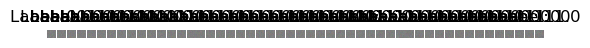

In [2]:
from matplotlib import pyplot as plt
import torchvision.transforms.functional as F


def show_images(images, labels):
    for i in range(images.size(0)):
        image = F.to_pil_image(images[i])
        plt.subplot(1, images.size(0), i + 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()


for batch_idx, (images, texts, labels) in enumerate(dataloader):
    print(
        f"Batch {batch_idx + 1} - Shape of images: {images.shape}, Texts: {texts}, Labels: {labels}"
    )

    # Visualize the images
    show_images(images, labels)
    
    if batch_idx == 2:  # Print information for the first 3 batches
        break

### Init Model

In [3]:
# Instantiate the model, dataset, and dataloader
model = OutfitCompatibilityModel()
focal_loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

c:\Users\phamm\.conda\envs\outfit_recommendation\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\phamm\.conda\envs\outfit_recommendation\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\phamm\.conda\envs\outfit_recommendation\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_t

### Training

In [4]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        images, texts, labels = batch  # Adjust this based on your dataset structure
        # Convert texts to a list of strings
        texts = list(texts)

        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = focal_loss(
            outputs, labels.unsqueeze(1)
        )  # Ensure labels have the right dimension
        loss.backward()
        optimizer.step()

        # Print or log the loss if needed
        print(f"Epoch {epoch + 1}, Batch loss: {loss.item()}")

    # Adjust the learning rate as needed (reduce by half in steps of 10)
    if (epoch + 1) % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group["lr"] = param_group["lr"] / 2

Epoch 1, Batch loss: 0.766801655292511
Epoch 1, Batch loss: 0.7276927828788757
Epoch 1, Batch loss: 0.6914207339286804
Epoch 1, Batch loss: 0.6850088238716125
Epoch 1, Batch loss: 0.705384373664856
Epoch 1, Batch loss: 0.717185378074646
Epoch 1, Batch loss: 0.6917112469673157
Epoch 1, Batch loss: 0.6923138499259949
Epoch 1, Batch loss: 0.6887170672416687
Epoch 1, Batch loss: 0.6933792233467102
Epoch 1, Batch loss: 0.6854708194732666
Epoch 1, Batch loss: 0.7005075216293335
Epoch 1, Batch loss: 0.7042722105979919
Epoch 1, Batch loss: 0.6876479983329773
Epoch 1, Batch loss: 0.6898249983787537
Epoch 1, Batch loss: 0.6932991743087769
Epoch 1, Batch loss: 0.6816087961196899
Epoch 1, Batch loss: 0.6848950982093811
Epoch 1, Batch loss: 0.6902981400489807


KeyboardInterrupt: 